## FEDn Quickstart (PyTorch)

This notebook provides an example of how to use the FEDn API to organize experiments and to analyze validation results. We will here run one training session (a collection of global rounds) using FedAvg, then retrive and visualize the results.

When you start this tutorial you should have a deployed FEDn Network up and running, and you should have created the compute package and the initial model, see the example README for instructions.

In [1]:
from fedn import APIClient
import time
import uuid
import json
import matplotlib.pyplot as plt
import numpy as np
import collections

We make a client connection to the FEDn API service. Here we assume that FEDn is deployed locally in pseudo-distributed mode with default ports.

In [2]:
DISCOVER_HOST = '192.168.2.56'
DISCOVER_PORT = 8092
client = APIClient(DISCOVER_HOST, DISCOVER_PORT)

In [11]:
client.set_active_package('package.tgz', 'numpyhelper')

{'message': 'Compute package set.', 'success': True}

Initialize FEDn with the compute package and seed model. Note that these files needs to be created separately by follwing instructions in the README.

In [12]:
client.set_active_package('package.tgz', 'numpyhelper')
client.set_active_model('seed.npz')
seed_model = client.get_active_model()
print(seed_model)

{'committed_at': 'Fri, 05 Jul 2024 04:34:44 GMT', 'id': '668777e4e9662c7152fb5c2c', 'key': 'models', 'model': 'c7888344-c7fe-43f8-97d6-85bcc6a1614e', 'parent_model': None, 'session_id': None}


In [13]:
session_id = "experiment002"

Next we start a training session using FedAvg and wait until it has finished:

In [14]:


session_config = {
                    "helper": "numpyhelper",
                    "id": session_id,
                    "aggregator": "fedavg",
                    "model_id": seed_model['model'],
                    "rounds": 300,
                    "round_timeout": 3000
                 }

result_fedavg = client.start_session(**session_config)

# We wait for the session to finish
while not client.session_is_finished(session_config['id']):
    time.sleep(2)

In [ ]:
client.session_is_finished(session_config['id'])

Next, we get the model trail, retrieve all model validations from all clients, extract the training accuracy metric, and compute its mean value accross all clients.

In [7]:
session_id = "experiment002"
models = client.get_model_trail()

acc = []
for model in models:
    
    model_id = model["model"]
    validations = client.get_validations(model_id=model_id)

    a = []
    for validation in validations['result']: 
        metrics = json.loads(validation['data'])
        a.append(metrics['test_accuracy'])
        
    acc.append(a)

mean_acc = [np.mean(x) for x in acc]

/home/ubuntu/volume/fedn/examples/IOT/.IOTH/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/volume/fedn/examples/IOT/.IOTH/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [7]:
!pip install matplotlib

  Using cached matplotlib-3.8.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached contourpy-1.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.51.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (159 kB)
  Using cached kiwisolver-1.4.5-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (6.4 kB)
  Using cached pillow-10.3.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (9.2 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
Using cached matplotlib-3.8.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
Using cached contourpy-1.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (305 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.51.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.6 MB)
Usi

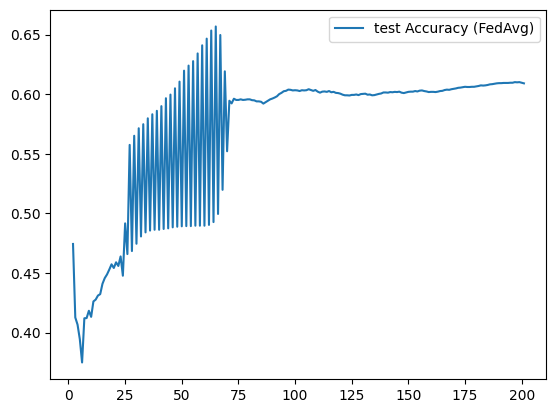

In [8]:
import matplotlib.pyplot as plt
x = range(1,len(mean_acc)+1)
plt.plot(x, mean_acc)
plt.legend(['test Accuracy (FedAvg)'])

In [10]:
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 35.0 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 KB 12.9 MB/s eta 0:00:00


/home/ubuntu/volume/fedn/examples/IOT/.IOTH/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/volume/fedn/examples/IOT/.IOTH/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


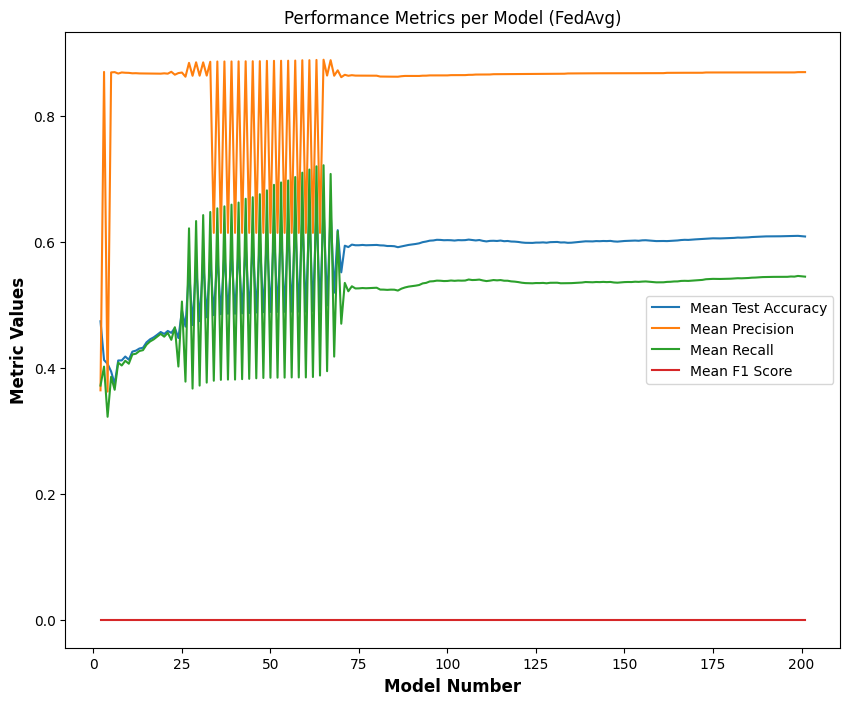

In [9]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'client' is predefined and has the necessary methods
session_id = "experiment002"
models = client.get_model_trail()  # Ensure this function exists and is correctly named

acc = []
precisions = []
recalls = []
f1_scores = []

for model in models:
    model_id = model["model"]
    validations = client.get_validations(model_id=model_id)  # Ensure this function exists and is correctly named

    a = []
    p = []
    r = []
    f1 = []
    for validation in validations['result']:
        metrics = json.loads(validation['data'])
        a.append(metrics.get('test_accuracy', 0))
        p.append(metrics.get('precision', 0))
        r.append(metrics.get('recall', 0))
        f1.append(metrics.get('f1_score', 0))
        
    acc.append(a)
    precisions.append(p)
    recalls.append(r)
    f1_scores.append(f1)

mean_acc = [np.mean(x) for x in acc]
mean_precisions = [np.mean(x) for x in precisions]
mean_recalls = [np.mean(x) for x in recalls]
mean_f1_scores = [np.mean(x) for x in f1_scores]

# Plotting all metrics
x = range(1, len(mean_acc)+1)
plt.figure(figsize=(10, 8))
plt.plot(x, mean_acc, label='Mean Test Accuracy')
plt.plot(x, mean_precisions, label='Mean Precision')
plt.plot(x, mean_recalls, label='Mean Recall')
plt.plot(x, mean_f1_scores, label='Mean F1 Score')

plt.xlabel('Model Number', fontdict={'fontsize': 12, 'fontweight': 'bold'})
plt.ylabel('Metric Values', fontdict={'fontsize': 12, 'fontweight': 'bold'})
plt.title('Performance Metrics per Model (FedAvg)')
plt.legend()
plt.savefig('model_metrics_plot_test_300R_epoch10_B256.png')  # Save the plot
plt.show()

# Saving metrics to CSV
data = {
    'Mean Test Accuracy': mean_acc,
    'Mean Precision': mean_precisions,
    'Mean Recall': mean_recalls,
    'Mean F1 Score': mean_f1_scores
}
df = pd.DataFrame(data)
df.to_csv('model_metrics_test_300_epoch10_B256.csv', index=False)


In [10]:
df.to_excel('model_metrics_300round_epoch10_B256.xlsx', index=False)

In [13]:
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 3.1 MB/s eta 0:00:000:00:01
